In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from math import isclose
import importlib 

import sys
sys.path.append("C:/Users/Leon/Documents/AI_project/AI_project")
from Image_processing.Preprocessing.utils import preprocessing as prep

***Show the Image***

***height (rows), width(cols)***

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [2]:
folders = ["Zwiebel", "Karotte", "Kartoffel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for i, fname in enumerate(os.listdir(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}"), 1):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}/{fname}")
        if i == 25:
            break
paths[25:50]  

['G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_1.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_2.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_3.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_4.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_5.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_6.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_7.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_8.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_9.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_10.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_11.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_12.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_13.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_14.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_15.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Karotte/karotte_16.jpg',
 'G:/Meine Ablage/KI_Projekt/Bild

In [2]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_65.jpg'] #karotte_trieb_17
# 209 previous karotte_trieb Trainingsdaten
paths = demo_img

In [19]:
importlib.reload(prep)

<module 'Image_processing.Preprocessing.utils.preprocessing' from 'C:\\Users/Leon/Documents/AI_project/AI_project\\Image_processing\\Preprocessing\\utils\\preprocessing.py'>

In [20]:
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels",
                                 "green onion pixels", "ratio area", "circularity", 
                                 "keypoints", "mean keypoints", "Label", "Image"])
error_counter = 0
resize_counter = 0
sym_test = {}
for i, path in enumerate(paths):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[4]
 
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = prep.resize_to_square(vegi_BGR) # BGR

    #try:
    ############################# Find Contours in image and draw a bounding box ##################################
    contour_vegi = prep.get_obj_contour(vegi_sq_BGR_original)

    # get and draw the bounding box
    rect = cv2.minAreaRect(contour_vegi)
    box = np.intp(cv2.boxPoints(rect))
    # draw bounding box
    vegi_with_box_rgb = cv2.drawContours(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB), 
                                         [box], 
                                         0, 
                                         (0, 255, 0), 2)

    ############################# Calculate the Circularity Feature ##################################
    circularity = prep.get_circularity(contour_vegi)

    ############################# Get pixel size from the bounding box (hight and width) ##################################
    #FIXME height and width are swapped. Use width and height from rect=(width, height)
    h, w = [int(l) for l in prep.get_size_box(box)]
    
    ############################# Calculate the Ratio Area Feature alias compactness ##################################
    ratio_area_box = 0
    area = cv2.contourArea(contour_vegi)
    if h > 0 and w > 0:
        ratio_area_box = area / (h * w)

    ############################# Crop the including area from the bounding box (our ROI) ##################################
    if not prep.is_box_rotated(box):
        #crop img directly
        # the top left corner should be the first element in box array
        cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w] 
    else:
        cropped_vegi_BGR = prep.crop_roi(vegi_sq_BGR_original, box) # BGR

    ############################# Do a binary segmentation only with the roi  ##################################
    cropped_segmented_binary_2 = prep.segment_img_2(cropped_vegi_BGR)
    #print("Segmented BINARY original")
    #prep.show_image_plt(cropped_segmented_binary_2, cmap="gray")

    ####################### TEST new segmentation #################################
    cropped_segmented_binary_3 = prep.segment_img_3(cropped_vegi_BGR)
    #print("Segmented BINARY From new Segmentation Method")
    #prep.show_image_plt(cropped_segmented_binary_3, cmap="gray")

    
    ############################# Apply the binary mask on the cropped image  ##################################
    cropped_vegi_segmented_rgb_2 = prep.color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR) # center has rgb format
    #print("Segmented RGB")
    #show_image_plt(cropped_vegi_segmented_rgb_2)

    ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
    num_kps, mean_kps = prep.sift(vegi_sq_BGR_original)

    ############################# Apply a green mask on the image ##################################
    # Seems to be work best
    vegi_only_onion_tribe_rgb, onion_tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
    #print("ONLY GREEn TRIBE MASK")
    #show_image_plt(vegi_only_onion_tribe_rgb)
    vegi_only_tribe_rgb, tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))

    ############################# Calculates the number of green pixels feature  ##################################
    amount_green_pixels_onion_tribe = prep.count_green_pixels(onion_tribe_mask)
    amount_green_pixels_tribe = prep.count_green_pixels(tribe_mask)

    ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
    center = prep.get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
    #print("center: ", center)
    R, G, B = np.max(center, axis=0)
    
    a = path.split(".")
    b = a[0].split("_")
    img_name = f"{vegi_label}_{b[-1]}"
    vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, vegi_label, img_name]
    #print(img_name)
    if i < 3:
        print(vegis_df)

    # check if any points are outside of the image if yes move them within the img boundaries
    resized_box = prep.recalculate_bounding_box(box)
    rotated_points = prep.rotate_edge_points(resized_box, rect[2])
    aligned_points = prep.align_edge_points(rotated_points)
    aligned_points = np.array([(prep.clip_aligned_points(x), prep.clip_aligned_points(y)) for x,y in aligned_points])

    # rotate img and draw new bounding box
    rotated_img = prep.rotate_img(vegi_with_box_rgb, rect[2])
    vegi_with_new_box_rgb = prep.draw_rotated_box(rotated_img, aligned_points)
    #print("Rotated Box")
    #prep.show_image_plt(vegi_with_new_box_rgb)
    #print("rect: ", aligned_points)
    sym_ = prep.calc_symmetry(vegi_with_new_box_rgb, aligned_points, "vertical")
    #print("Sym value: ", sym_)
    
    #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/Debugging_resize_function_v3/{img_name}_{i}.jpg", cv2.cvtColor(vegi_with_new_box_rgb, cv2.COLOR_BGR2RGB))
    #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/originally_box/{img_name}_{i}.jpg", cv2.cvtColor(vegi_with_box_rgb, cv2.COLOR_BGR2RGB))
    #if i == 6:
    #    break
    #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/Debugging_binary_seg_3_blurred/{img_name}_{i}.jpg", cropped_segmented_binary_3)
    
    """
    try:
        new_img, new_box = prep.resize_bound_box_and_draw(vegi_with_box_rgb, rect, box)
        #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/Debugging_resize_function/{img_name}_{i}.jpg", new_img)
    except Exception as e:
        resize_counter += 1
        print(e)
    """ 
    #except Exception as e:
    #    print(f"########## Error: {e}")
    #    error_counter += 1
    

   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    111     74  117  71  52             0                   0    0.730825   

   circularity  keypoints  mean keypoints    Label      Image  
0     0.623236         31        8.244542  Zwiebel  Zwiebel_1  
   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    111     74  117  71  52             0                   0    0.730825   
1    184    120  118  74  57             0                   0    0.385303   

   circularity  keypoints  mean keypoints    Label      Image  
0     0.623236         31        8.244542  Zwiebel  Zwiebel_1  
1     0.233313         26        9.245802  Zwiebel  Zwiebel_2  
   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    111     74  117  71  52             0                   0    0.730825   
1    184    120  118  74  57             0                   0    0.385303   
2    123    117   79  51  57           214            

v_line_before:  126
h_line_before:  134
v_line:  126
h_line:  134
(126, 134)
center:  (145, 139)


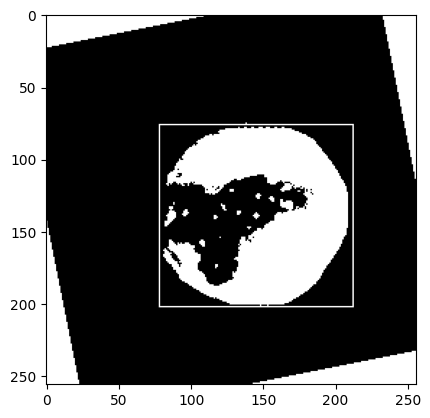

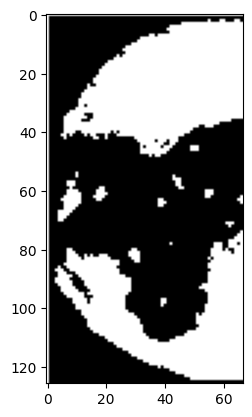

shape left_half_  (126, 67)
vertical flip


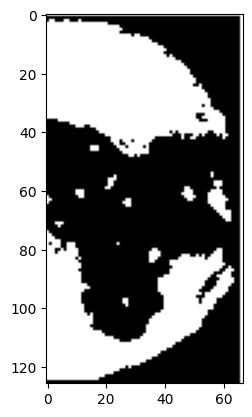

crop from rotated box


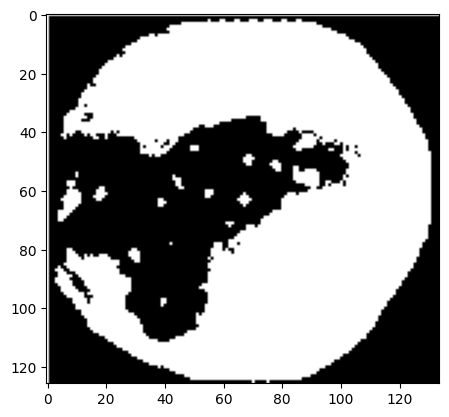

mirror left half


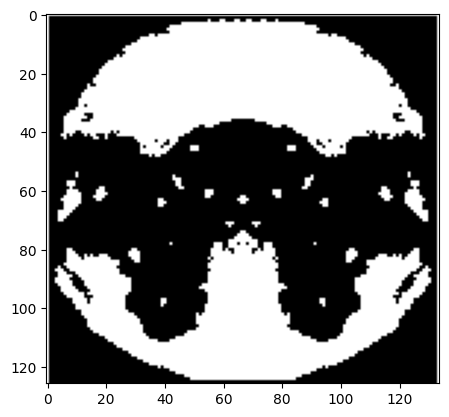

shape left_half:  (126, 67)
shape v_flip:  (126, 134)


In [7]:
vegi_box = vegi_with_new_box_rgb.copy()
#vegi_box = cv2.cvtColor(vegi_box, cv2.COLOR_RGB2GRAY)
vegi_box = prep.segment_img_2(vegi_box)
# width and weight should be a even number because later it's easier to calculate
v_line = int(np.linalg.norm(aligned_points[1] - aligned_points[0]))
h_line = int(np.linalg.norm(aligned_points[3] - aligned_points[0]))
print("v_line_before: ", v_line)
print("h_line_before: ", h_line)
aligned_points = aligned_points.copy()
# if the length of the lines are odd values then remove one pixel row and/or column
if v_line % 2 != 0:
    v_line -= 1
    aligned_points[1][1] += 1
    aligned_points[2][1] += 1
if h_line % 2 != 0:
    h_line -= 1
    aligned_points[2][0] -= 1
    aligned_points[3][0] -= 1

print("v_line: ", v_line)
print("h_line: ", h_line)

# crop new box
crop_new_box = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]:aligned_points[1][0]+h_line]
#crop_new_box = vegi_box[aligned_points[1][1]:aligned_points[0][1], aligned_points[1][0]:aligned_points[2][0]]

print(crop_new_box.shape)

# calc center point. Only needed for debugging
center = (aligned_points[1][0] + (h_line // 2)), (aligned_points[1][1] + (v_line // 2))
assert isclose(int(np.linalg.norm(aligned_points[1] - center)), int(np.linalg.norm(aligned_points[2] - center)), abs_tol=1), "Center is not in the middle of the box"
print("center: ", center)
cv2.line(vegi_box, center, center, (255, 0, 255), 4)
prep.show_image_plt(vegi_box, cmap="gray")

# crop vertical along vertical sym line
#cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w] 
# array rows corresponds to img height
left_half = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]:aligned_points[1][0]+(h_line // 2)]
prep.show_image_plt(left_half, cmap="gray")
print("shape left_half_ ", left_half.shape)
left_half_v_flipped = cv2.flip(left_half, 1)
print("vertical flip")
prep.show_image_plt(left_half_v_flipped, cmap="gray")


# stack horizontally
v_flip = np.concatenate((left_half, left_half_v_flipped), axis=1)
print("crop from rotated box")
prep.show_image_plt(crop_new_box, cmap="gray")
print("mirror left half")
prep.show_image_plt(v_flip, cmap="gray")

print("shape left_half: ", left_half.shape)
print("shape v_flip: ", v_flip.shape)

left half flipped


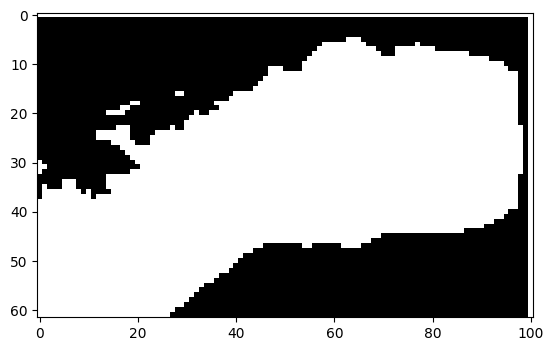

orig


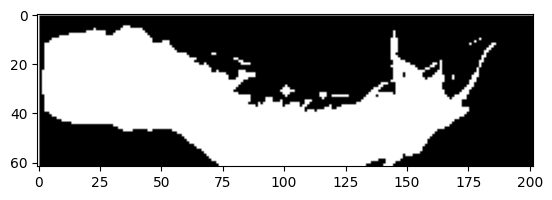

right half


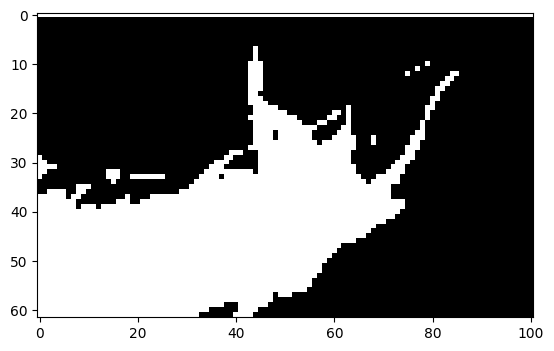

overlap_count:  1814
orig_area:  3598
sym:  0.5041689827682045


In [55]:
print("left half flipped")
plt.imshow(left_half_v_flipped, cmap="gray")
plt.show()
print("orig")
plt.imshow(crop_new_box, cmap="gray")
plt.show()
right_half = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]+(h_line // 2):aligned_points[2][0]]
print("right half")
plt.imshow(right_half, cmap="gray")
plt.show()
assert left_half.shape == right_half.shape, "Shapes are not equal"

# really slow algorithm - iterate over each pixel in flipped img and compare if the pixel exist in the original img
overlap_count = 0
for row in range(left_half_v_flipped.shape[0]):
    for col in range(left_half_v_flipped.shape[1]):
        if left_half_v_flipped[row][col] != 0 and left_half_v_flipped[row][col] == right_half[row][col]:
            overlap_count += 1
        else:
            continue

orig_area = np.unique(left_half_v_flipped, return_counts=True)[1][1]
# min = 0, max = 1
sym = overlap_count / orig_area
print("overlap_count: ", overlap_count)
print("orig_area: ", orig_area)
print("sym: ", sym)

In [85]:
right_half.shape
left_half_v_flipped.shape

(204, 92)

In [86]:
right_half.shape

(204, 93)

In [69]:
aligned_points

array([[ 53, 206],
       [ 53,   2],
       [238,   2],
       [238, 206]])

In [89]:
print(arr_flipped.shape)
print(arr_right_half.shape)

(18768,)
(18768,)


In [88]:
print(left_half_v_flipped.shape)
print(right_half.shape)

(204, 92)
(204, 92)


In [108]:
sym_ = prep.calc_symmetry(vegi_with_new_box_rgb, aligned_points, "vertical")
print(sym_)

0.5


In [106]:
right_half = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]+(h_line // 2):aligned_points[2][0]]
print()
arr_flipped = left_half_v_flipped.flatten()
arr_right_half = right_half.flatten()
assert arr_flipped.shape == arr_right_half.shape

overlap_count = np.sum((arr_flipped == 255) & (arr_right_half == 255))

orig_area = np.unique(left_half_v_flipped, return_counts=True)[1][1]
# min = 0, max = 1
sym = overlap_count / orig_area
print("overlap_count: ", overlap_count)
print("orig_area: ", orig_area)
print("sym: ", sym)


overlap_count:  1814
orig_area:  3598
sym:  0.5041689827682045


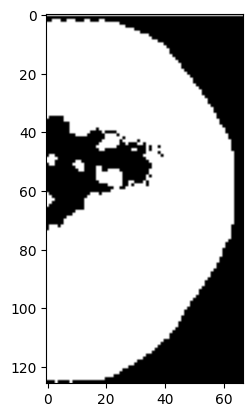

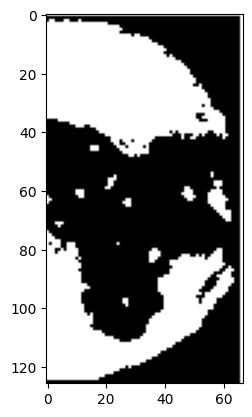

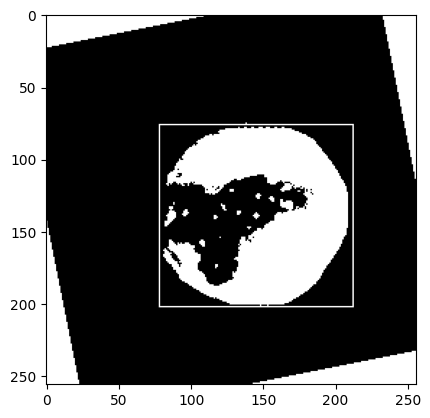

In [102]:
prep.show_image_plt(right_half, cmap="gray")
prep.show_image_plt(left_half_v_flipped, cmap="gray")
prep.show_image_plt(vegi_box, cmap="gray")


The resized image to 256x256 pixels


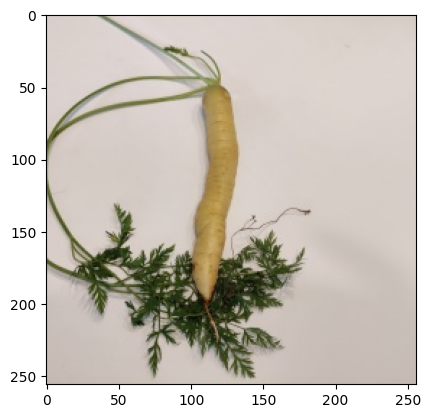

Shows the bounding box which was drawed around the founded contours


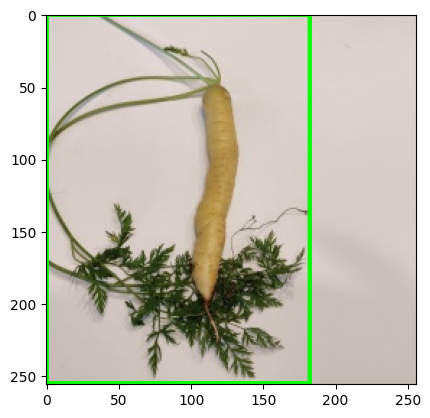

Segmented Binary Image 


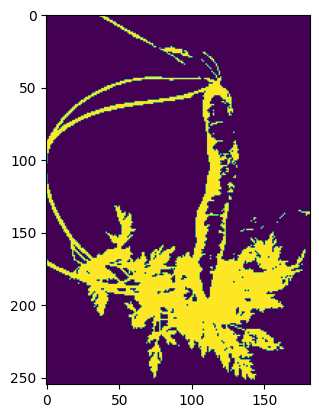

Segmented Image after applying the binary mask


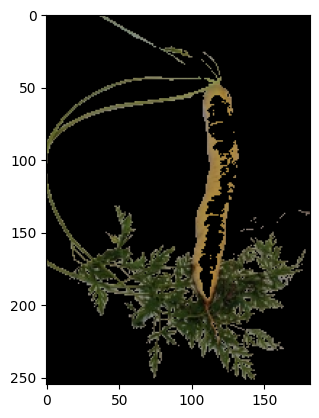

Shows the green color mask to get only the green pixels from the image


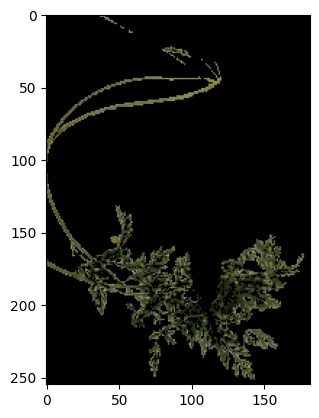

In [121]:
print("The resized image to 256x256 pixels")
prep.show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

print("Shows the bounding box which was drawed around the founded contours")
prep.show_image_plt(vegi_with_box_rgb)

print("Segmented Binary Image ")
prep.show_image_plt(cropped_segmented_binary_2)

print("Segmented Image after applying the binary mask")
prep.show_image_plt(cropped_vegi_segmented_rgb_2)

print("Shows the green color mask to get only the green pixels from the image")
prep.show_image_plt(vegi_only_onion_tribe_rgb)

In [ ]:
#vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/.csv")